In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn.datasets
#import sklearn.feature_extraction.text
#import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
sns.set()
import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show
from collections import Counter

import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


Loading BokehJS ...

# NCI Datasets

We build one large graph that really consists of 4000+ smaller ones (there are 2 datasets, NCI1 and NCI109).
For each vertex, we have the following attributes:
* name:  unique for each vertex (1-based str)
* graph: id of the small graph this node belongs to (1-based int)
* label: the vertex label (1-based int)

Note that some vertices are assigned to a small graph, but are not part of any edge.
When extracting the small graphs, we consider the giant connected component only.

Each small graph belongs to one of two classes; the classes are roughly balanced.


In [2]:
dataset = 'NCI109'
datadir = '../Data/'+dataset+'/'

## read data from NCI folder
fn_edges = datadir+'DS_A.txt'
fn_graph_id = datadir+'DS_graph_indicator.txt'
fn_graph_label = datadir+'DS_graph_labels.txt'
fn_node_label = datadir+'DS_node_labels.txt'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip())-1 for x in f.readlines()]

## build dictionary (node names are 1-based)
graph_dict = {(x+1):y for x,y in enumerate(sg_mem)}
for v in G.vs:
    v['graph'] = graph_dict[v['name']]

## read and store node labels
with open(fn_node_label) as f:
    nl = [int(x.strip()) for x in f.readlines()]
nl_dict = {(x+1):y for x,y in enumerate(nl)}
for v in G.vs:
    v['label'] = nl_dict[v['name']]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]
print('number of graphs:',len(graph_labels))


number of graphs: 4127


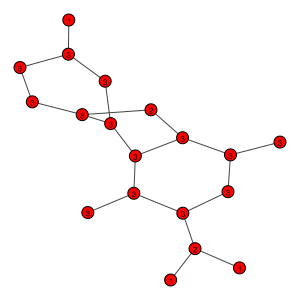

In [4]:
## subgraphs are easy to get
sg_id = 0
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_id)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=12, vertex_label_size=8)

## Method 2 - walks

Very simple random fixed length random walks, for comparison only.

We can either include the node labels or not (default = include).


In [5]:
## number and length of walks per graph
walk_len = 10
walk_nbr = 100

## if false, use only the degrees
use_node_labels = True


In [6]:
%%time
## Build walks
L1 = []
rows = []
for i in range(max(G.vs['graph'])+1):
    L2 = []
    ## use giant CC
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist()).connected_components().giant()
    Deg = sg.degree()
    Lab = sg.vs['label']
    n = sg.vcount()
    rows.extend(np.repeat(i,n))
    ctr = 0
    while ctr<walk_nbr:
        marche = sg.random_walk(start=np.random.choice(n), steps=walk_len-1)
        if len(marche)==walk_len:
            if use_node_labels:
                v = [str(Deg[k])+'_'+str(Lab[k]) for k in marche]
            else:
                v = [str(Deg[k]) for k in marche]
            L2.append(np.array(v))
            ctr += 1
    L2 = np.array(L2)
    L1.append(L2)
L = np.array(L1, dtype=object)
walks = np.vstack(L)
walks.shape


CPU times: user 30.7 s, sys: 116 ms, total: 30.8 s
Wall time: 30.8 s


(412700, 10)

In [7]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=(1,5),
    window_functions=("fixed", "variable"),
    kernel_functions=("geometric", "geometric"),
    kernel_args=({}, {"offset":1}),
    n_iter=2,
    normalize_windows=True,
    n_threads=32
).fit(walks)
word_vectors = word_vectorizer.transform(walks)


CPU times: user 4min 25s, sys: 944 ms, total: 4min 26s
Wall time: 55.7 s


In [8]:
%%time
ngrammer = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
)
doc_matrix = ngrammer.fit_transform(walks)

CPU times: user 16.5 s, sys: 314 ms, total: 16.8 s
Wall time: 16.8 s


In [9]:
%%time
n_g = len(set(G.vs['graph']))
Inc = np.array(np.arange(0,n_g*walk_nbr)).reshape((n_g,walk_nbr))
inc_matrix = vectorizers.NgramVectorizer(
).fit_transform(Inc)


CPU times: user 1.46 s, sys: 42.1 ms, total: 1.5 s
Wall time: 1.5 s


In [10]:
## un-normalized
awe_matrix = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(inc_matrix, vectors=doc_matrix)

In [11]:
## normalized
doc_matrix_norm = normalize(doc_matrix, axis=1, norm='l1')
awe_matrix_norm = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(inc_matrix, vectors=doc_matrix_norm)

In [12]:
import pickle
fn = 'Results/walks_'+dataset+'.pkl'
with open(fn,'wb') as fp:
    pickle.dump( (awe_matrix,awe_matrix_norm), fp)
